# autoencoder experiment on freehic simulated data set
applying autoencoder to simluated data to denoise and reveal important features. autoencoder follows the pipeline:
- build autoencoder with a few convolution layers
- use unsupervised autoencoder to decode query matrix, removing noise and revealing important features

## imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fanc
import fanc.plotting
from scipy import ndimage as ndi
import matplotlib.patches as patches
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

## define helper functions

In [2]:
def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

def highlight_features(dataframe, region, color, a, axes):
    try:
        features = dataframe.loc[region].values.tolist()
        if type(features[0]) == int:
            _, x_min, x_max, y_min, y_max = features
            rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                     edgecolor=color, facecolor='none')
            axes[a].add_patch(rect)
        else:
            for f in features:
                _, x_min, x_max, y_min, y_max = f
                rect = patches.Rectangle((x_min,y_min),x_max-x_min,y_max-y_min,linewidth=1.2,
                                         edgecolor=color, facecolor='none')
                axes[a].add_patch(rect)
                
    except KeyError:
        next

def mean_squared_error(original: np.array, denoised: np.array) -> float:
    return np.mean((original - denoised) ** 2)

def clip_rotate(matrix):
    zm = clipped_zoom(matrix, 0.7)
    rot_clipped = ndi.rotate(zm, 45, reshape=False)
    return rot_clipped

## autoencoder function

In [3]:
# Build Autoencoder
def build_autoencoder(input_dim, encoding_dim):
    model = Sequential()
    model.add(Dense(encoding_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(input_dim, activation='linear'))  # Linear output activation
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def apply_autoencoder(matrix, encode_dim):
    model = build_autoencoder(input_dim=len(matrix), encoding_dim=encode_dim)
    # Normalize the matrix
    scaler = MinMaxScaler()
    matrix_scaled = scaler.fit_transform(matrix)
    
    model.fit(matrix_scaled, matrix_scaled, epochs=100, batch_size=32)
    denoised_matrix_scaled = model.predict(matrix_scaled) # denoise
    
    denoised_matrix = scaler.inverse_transform(denoised_matrix_scaled) # rescale
    return denoised_matrix

## load hic data

In [4]:
wdir = "../data/syn/"

orig_data = fanc.load(wdir + "binned/orig/GSM1215593_trimmedAndFiltered-TROPHOZOITES-XL-AGGG-L2_5kb.hic")
sim_data = fanc.load(wdir + "binned/sim/GSM1215593_trimmedAndFiltered-TROPHOZOITES-XL-AGGG-L2_5kb.hic")

region_string = "chr1:0-650000"

orig_data_sub = orig_data[region_string, region_string].data
sim_data_sub = sim_data[region_string, region_string].data

min_v = min(
    [
        np.min(np.extract(orig_data_sub>0 , orig_data_sub)),
        np.min(np.extract(sim_data_sub>0 , sim_data_sub))
    ]
)

orig_data_sub += min_v
sim_data_sub += min_v

## apply autoencoder to hic data

In [5]:
# set size of encoding dim, should be some fraction of input matrix size
latent_space_size = 60

# ------ apply autoencoder ------
auto_orig = apply_autoencoder(orig_data_sub, latent_space_size)

auto_sim = apply_autoencoder(sim_data_sub, latent_space_size)

# Compute autoencoder difference matrix (patient - control)
diff_auto1 = auto_orig - auto_sim # auto_matrix1 - auto_matrix2

# subtract inverse (control - patient)
diff_auto2 = auto_sim - auto_orig

# log2(obs/exp) calc
safe_div = auto_sim / auto_orig

safe_div[safe_div == 0] = np.nan
safe_div = abs(safe_div)
log_auto1 =  np.log2(safe_div) # pca_matrix1 / pca_matrix2 of pca applied

log_auto2 =  np.log2(sim_data_sub / orig_data_sub ) # patient / control of normal matrices

Epoch 1/100


/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255  
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0226 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0183 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 
Epoch 16/100
5/5 ━━━━━━━━━━━━━

/Users/fardinhaque/Downloads/SJSU/Research/hic_compare_experiments/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0463  
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0398 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0348 
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0285 
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0261 
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 
Epoch 16/100
5/5 ━━━━━━━━━━━━━

## generate plots

Plot saved to out/syn_autoencoder_hic.png


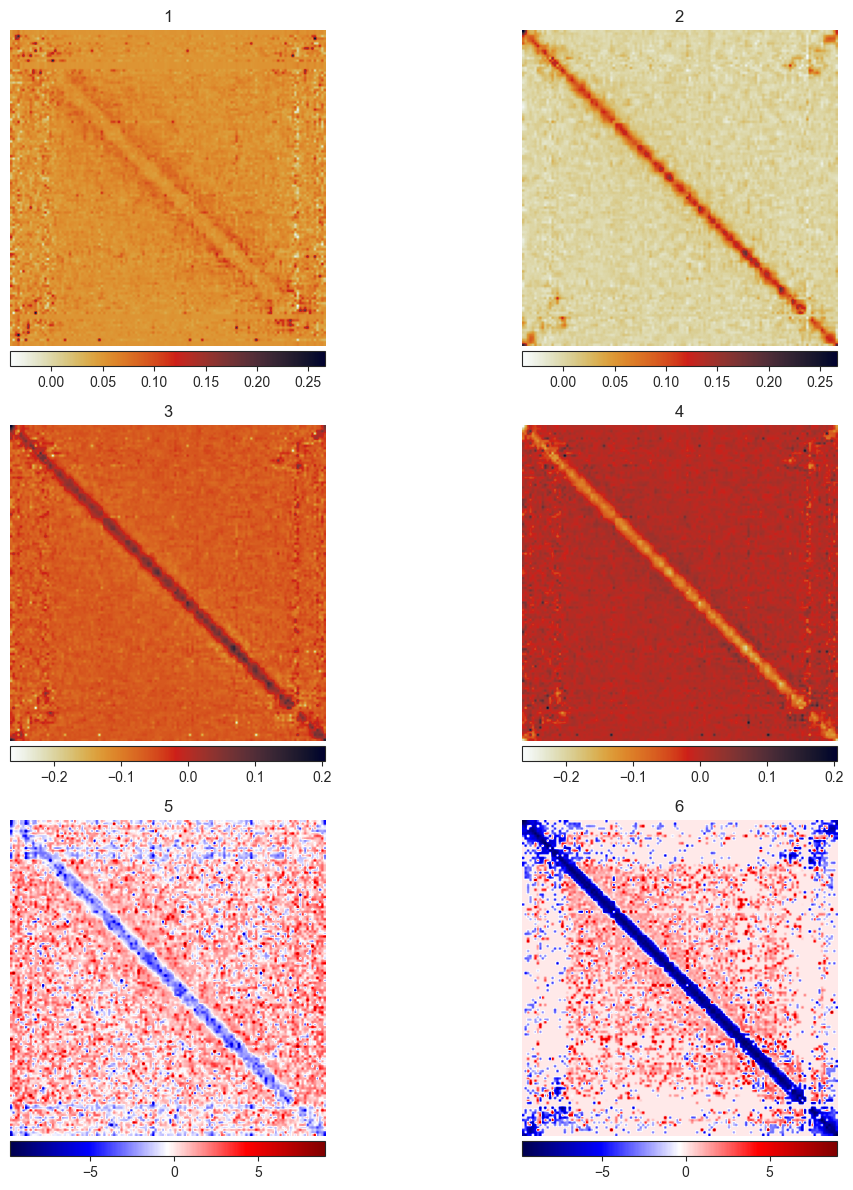

In [7]:
# Plot heatmaps in a grid layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# middle = int(np.shape(rot_control)[1]/ 2.)

# Second row: PCA transformed matrices
m1 = axes[0][0].imshow(auto_sim, cmap='germany')
axes[0, 0].set_title("1")

m2 = axes[0][1].imshow(auto_orig, cmap='germany')
axes[0, 1].set_title("2")

# Third row: Difference matrix spanning two columns
m3 = axes[1][0].imshow(diff_auto1, cmap='germany')
axes[1, 0].set_title("3")

m4 = axes[1][1].imshow(diff_auto2, cmap='germany')
axes[1, 1].set_title("4")

# Fourth Row:
# apply log2(obs/exp) from pca modified matrices and raw matrices
m5 = axes[2][0].imshow(log_auto1, cmap='seismic')
axes[2, 0].set_title("5")

m6 = axes[2][1].imshow(log_auto2, cmap='seismic')
axes[2, 1].set_title("6")

color_bars = [m1, m2, m3, m4, m5, m6]

for i in range(0, len(axes)):
    for m, ax in zip([color_bars[i*2+1], color_bars[i*2+1]], axes[i]):
        ax.axis('off')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='5%', pad=0.05)
        fig.colorbar(m, cax=cax, orientation='horizontal') 

# Adjust layout
plt.tight_layout()

# save plot
save_path = os.path.join("out", "syn_autoencoder_hic.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')  # High resolution and tight layout

print(f"Plot saved to {save_path}")
# TODO mse value calc
# mse_value = mean_squared_error(pca_matrix1, patient_region_sub)
# print(f"mse value {mse_value}")